# 0 - Importing Libraries & Dependencies

In [ ]:
# Note - Saving checkpoint for 74% r2 + 58% validation

In [283]:
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install statsmodels

In [284]:
# Map Dependencies
# Note that this is necessary to get the dev version of geopandas, which is what I want. Plus, I want to avoid usign conda (An alternative).
# Files come from here: https://www.lfd.uci.edu/~gohlke/pythonlibs

#pip3 install .\GDAL-3.2.2-cp39-cp39-win_amd64.whl
#pip3 install .\Fiona-1.8.19-cp39-cp39-win_amd64.whl
#pip3 install .\Shapely-1.7.1-cp39-cp39-win_amd64.whl
#pip3 install .\Rtree-0.9.7-cp39-cp39-win_amd64.whl
#pip3 install https://github.com/geopandas/geopandas/archive/master.zip

In [285]:
## Import Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose #Special note to this
from sklearn import preprocessing
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math
from scipy.stats import norm, skew
import warnings
import geopandas as gpd
import requests

import time

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [286]:
# Basic Configs
pd.set_option('display.max_rows', 80) # Allowing more rows to be printed in the nb

In [287]:
cityName = "Toronto"
raw_df = pd.read_csv("../input/Toronto/2021-02-08/listings.csv")

#cityName = "Rio de janeiro"
#raw_df = pd.read_csv("../input/Rio-de-janeiro/2021-02-22/listings.csv")

df = raw_df
df.set_index('id', inplace=True) # ID as index

# Basic Data Exploration

In [288]:
print(raw_df.shape)
print(raw_df.info())

(15832, 73)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15832 entries, 1419 to 48082311
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   15832 non-null  object 
 1   scrape_id                                     15832 non-null  float64
 2   last_scraped                                  15832 non-null  object 
 3   name                                          15831 non-null  object 
 4   description                                   15267 non-null  object 
 5   neighborhood_overview                         9882 non-null   object 
 6   picture_url                                   15832 non-null  object 
 7   host_id                                       15832 non-null  int64  
 8   host_url                                      15832 non-null  object 
 9   host_name                                  

In [289]:
print(raw_df.describe())

          scrape_id       host_id  host_listings_count  \
count  1.583200e+04  1.583200e+04         15816.000000   
mean   2.021020e+13  1.144734e+08             6.206942   
std    0.000000e+00  1.104414e+08            18.412277   
min    2.021020e+13  1.565000e+03             0.000000   
25%    2.021020e+13  2.163128e+07             1.000000   
50%    2.021020e+13  7.184278e+07             1.000000   
75%    2.021020e+13  1.903582e+08             4.000000   
max    2.021020e+13  3.873458e+08           272.000000   

       host_total_listings_count  neighbourhood_group_cleansed      latitude  \
count               15816.000000                           0.0  15832.000000   
mean                    6.206942                           NaN     43.682340   
std                    18.412277                           NaN      0.049393   
min                     0.000000                           NaN     43.586740   
25%                     1.000000                           NaN     43.645650 

# Data Cleaning

In [290]:
# Performance Monitoring
rawMemoryUsed = round(raw_df.memory_usage(deep=True).sum()/1000000,1)
rawRowsUsed = raw_df.shape[0]
rawColsUsed = raw_df.shape[1]

print("Raw dataframe uses " + str(rawRowsUsed) + " rows and " + str(rawColsUsed) + " columns with "+ str(rawMemoryUsed) + " mb of memory")


Raw dataframe uses 15832 rows and 73 columns with 72.6 mb of memory


## Converting price String → Floats

In [291]:
# Removing $ from price column (e.g. $ 3,320.00 -> 3,320.00)
df["price"] = df["price"].str.replace('$', '')

# Removing ',' from price column (e.g. $ 3,320.00 -> 3320.00)
df["price"] = df["price"].str.replace(',', '')

# Converting to floats
df["price"] = df["price"].astype(float)


In [292]:
df["price"].describe()

count    15832.000000
mean       136.679573
std        316.199774
min          0.000000
25%         60.000000
50%         93.000000
75%        148.000000
max      13000.000000
Name: price, dtype: float64

## Converting all columns with "t" / "f" → 1 / 0

In [293]:
# Replacing columns with f (false) or t (True) for 0 or 1
df.replace({'f': 0, 't': 1}, inplace=True)

## We'll drop columns that will not be used in this project, as many of those are not relevant to the data at hand.

In [294]:
text_cols = ['name', 'description', 'neighborhood_overview', 'host_name', 'host_location', 'host_about', 'host_neighbourhood', 'host_verifications']
id_cols = ['scrape_id', 'host_id']
metadata_cols = ['last_scraped', 'calendar_last_scraped']
url_cols = ['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']

drop_columns = text_cols + id_cols + metadata_cols + url_cols
print ("Dropping a total of " + str(len(drop_columns)) + " columns.")

df = raw_df.drop(drop_columns, axis=1)
#TODO Consider using column "Name", "neighborhood_overview", "host_about" + NLP
#TODO "host_has_profile_pic" NAs should actually become falses

# Performance
print("df is currently using " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns and " + str(round(df.memory_usage(deep=True).sum()/1000000,1)) + " mb of memory")

Dropping a total of 17 columns.
df is currently using 15832 rows and 56 columns and 24.2 mb of memory


In [295]:
# Getting columns that have a lot of na() values, converting it to a dataframe, and adding a col with % of total

isNASeries = df.isna().sum()
isNAdf = pd.DataFrame({'column_name':isNASeries.index, 'Sum_NA':isNASeries.values, "Percent_NA":(isNASeries.values/df.shape[0]*100)})

# Getting the columns that have more than 20% of total as NAs, and dropping them.
drop_columns = isNAdf[isNAdf.Percent_NA > 30]["column_name"]
print("Dropping a total of " + str(len(drop_columns)) + " columns. Those are: ")
print(isNAdf[isNAdf.Percent_NA > 30])


df.drop(drop_columns, axis=1, inplace=True)

#TODO: Use NLP on host_response_time
#TODO: host_response_rate & host_acceptance_rate could also be useful
#TODO: Check if licensed hosts have more shit?
print("df is currently using " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns and " + str(round(df.memory_usage(deep=True).sum()/1000000,1)) + " mb of memory")

Dropping a total of 8 columns. Those are: 
                     column_name  Sum_NA  Percent_NA
1             host_response_time    6648   41.990904
2             host_response_rate    6648   41.990904
3           host_acceptance_rate    5073   32.042698
9                  neighbourhood    5950   37.582112
11  neighbourhood_group_cleansed   15832  100.000000
17                     bathrooms   15832  100.000000
31              calendar_updated   15832  100.000000
49                       license   12047   76.092724
df is currently using 15832 rows and 48 columns and 19.8 mb of memory


In [296]:
# Here we can see that host_listing_count is exatly the same as host_total_listings_count. So we can drop one. In this case, we'll drop host_total_listings_count

print(sum((df.host_listings_count == df.host_total_listings_count) == False))
print(df.host_listings_count.isna().sum())

drop_columns = "host_total_listings_count"

df.drop(drop_columns, axis=1, inplace=True)

16
16


In [297]:
# There are calculated columns by who uploaded the data that tries to process what are entire homes, private rooms or shared rooms. We'll remove those since well be doing this processing ourselves.test_df

drop_columns = ["calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"]
df.drop(drop_columns, axis=1, inplace=True)
print("df is currently using " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns and " + str(round(df.memory_usage(deep=True).sum()/1000000,1)) + " mb of memory")

df is currently using 15832 rows and 43 columns and 19.1 mb of memory


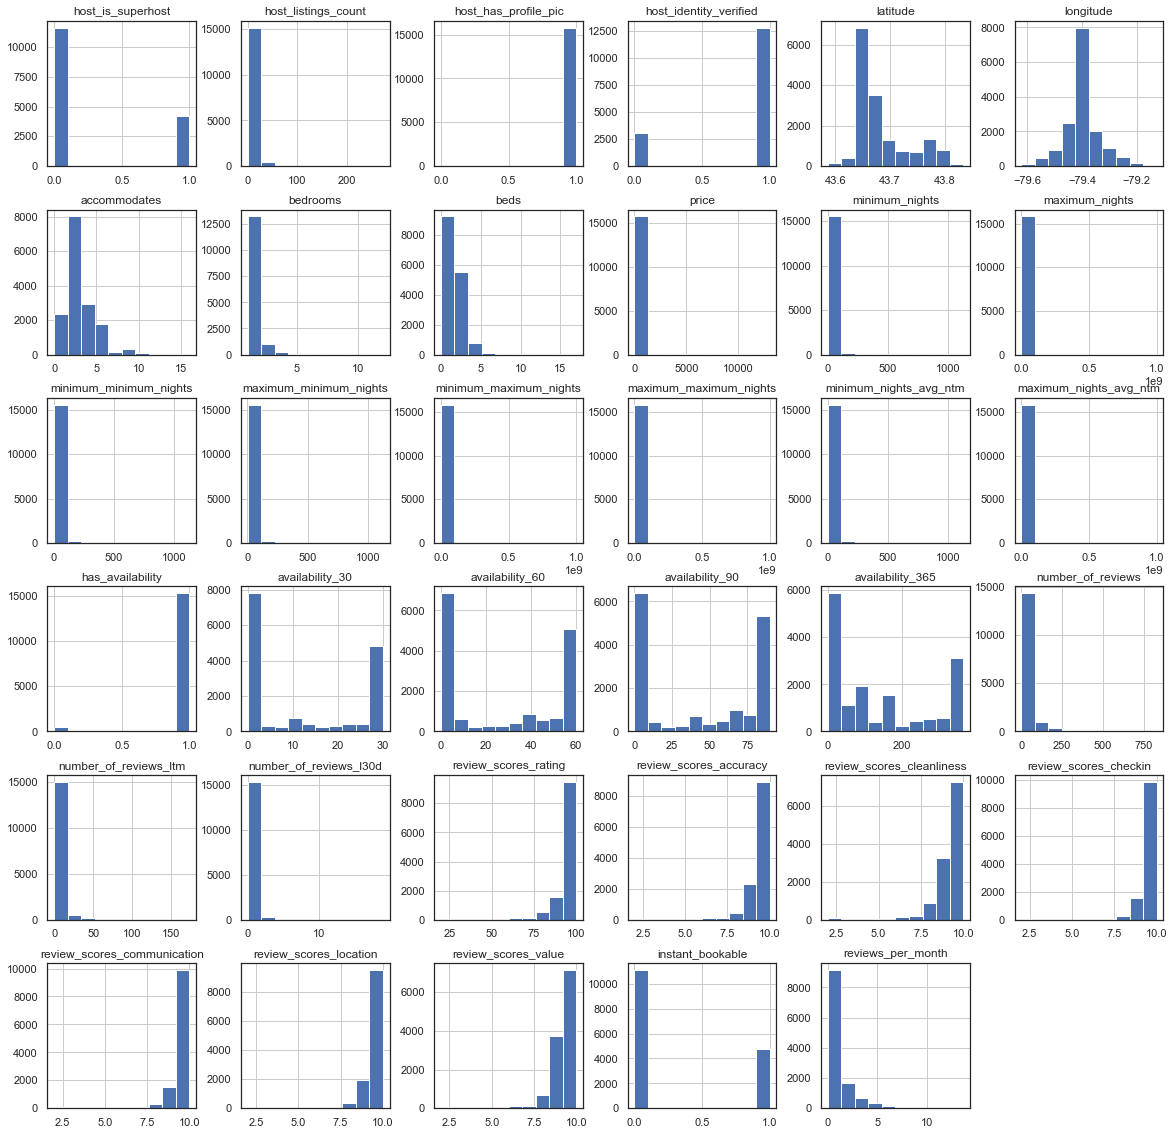

In [298]:
# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [299]:
df["host_since"]

id
1419        08-08-08
8077        22-06-09
23691       15-03-10
27423       04-05-10
30931       22-06-09
              ...   
48082008    25-11-16
48082033    19-07-20
48082242    19-02-18
48082302    23-06-16
48082311    25-08-20
Name: host_since, Length: 15832, dtype: object

## Property & Room Types

In [300]:
# Interessante que temos 2 RVs e 3 boats
df.property_type.value_counts()

Entire condominium                    3706
Entire apartment                      3282
Private room in house                 2534
Entire house                          1629
Private room in apartment             1064
Entire guest suite                     623
Private room in condominium            584
Private room in townhouse              408
Private room in bungalow               355
Entire townhouse                       290
Entire loft                            267
Entire bungalow                        188
Private room in guest suite            130
Shared room in house                    89
Room in boutique hotel                  85
Private room in villa                   71
Shared room in apartment                65
Private room in guesthouse              49
Entire guesthouse                       46
Room in hotel                           40
Shared room in condominium              37
Entire serviced apartment               36
Private room in bed and breakfast       34
Shared room

In [301]:
#Airbnb definition: https://www.airbnb.com/help/article/317/what-do-the-different-home-types-mean

df.property_type.replace({
"Entire condominium"                : "Apartment",
"Entire apartment"                  : "Apartment",
"Private room in house"             : "House",
"Entire House"                      : "House",
"Private room in apartment"         : "Apartment",
"Entire guest suite"                : "Apartment",
"Private room in condominium"       : "Apartment",
"Private room in townhouse"         : "House",
"Private room in bungalow"          : "House",
"Entire townhouse"                  : "House",
"Entire loft"                       : "Apartment",
"Entire bungalow"                   : "House",
"Private room in guest suite"       : "Apartment",
"Shared room in house"              : "House",
"Room in boutique hotel"            : "Apartment",
"Private room in villa"             : "House",
"Shared room in apartment"          : "Apartment",
"Private room in guesthouse"        : "House",
"Entire guesthouse"                 : "House",
"Room in hotel"                     : "Apartment",
"Shared room in condominium"        : "Apartment",
"Entire serviced apartment"         : "Apartment",
"Shared room in townhouse"          : "House",
"Private room in loft"              : "Apartment",
"Room in hostel"                    : "Apartment",
"Entire villa"                      : "House",
"Private room in serviced apartment": "Apartment",
"Room in aparthotel"                : "Apartment",
"Shared room in tiny house"         : "House",
"Shared room in bungalow"           : "House",
"Private room in tiny house"        : "House",
"Tiny house"                        : "House",
"Private room in hostel"            : "Apartment",
"Private room in cottage"           : "House",
"Entire cottage"                    : "House",
"Entire house"                      : "House",
}, inplace = True)

# Replacing other categories with 'other'
#df.loc[~df.property_type.isin(['Entire place', 'Private room', 'Shared room']), 'property_type'] = 'Other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [302]:
# Seeing new count and adding a % total
propertyTypesSeries = df.property_type.value_counts()
propertyTypesdf = pd.DataFrame({'Property Type':propertyTypesSeries.index, 'Sum':propertyTypesSeries.values, "Percent_Total":(propertyTypesSeries.values/df.shape[0]*100)})
propertyTypesdf

,Property Type,Sum,Percent_Total
0,Apartment,9998,63.150581
1,House,5742,36.268317
2,Other,92,0.581102


In [303]:
# Seeing new count and adding a % total
roomTypesSeries = df.room_type.value_counts()
roomTypesdf = pd.DataFrame({'Property Type':roomTypesSeries.index, 'Sum':roomTypesSeries.values, "Percent_Total":(roomTypesSeries.values/df.shape[0]*100)})
roomTypesdf

,Property Type,Sum,Percent_Total
0,Entire home/apt,10122,63.933805
1,Private room,5415,34.202880
2,Shared room,246,1.553815
3,Hotel room,49,0.309500


## Bathrooms

In [304]:
# Note that half a bathroom → Just toilet and sink, no tub or shower "Half Bath"
# https://community.withairbnb.com/t5/Help/Meaning-of-Indicating-bathroom-as-1-or-0-5/td-p/105155

df.bathrooms_text.value_counts()

1 bath               7958
1 shared bath        2586
2 baths              1743
1 private bath       1319
1.5 baths             695
1.5 shared baths      367
2 shared baths        346
2.5 baths             244
3 baths               187
3.5 baths              78
3 shared baths         57
2.5 shared baths       44
4 baths                35
4.5 baths              30
0 shared baths         27
0 baths                20
Shared half-bath       16
3.5 shared baths       13
5 baths                 9
Half-bath               9
5.5 baths               6
Private half-bath       6
6 baths                 5
4 shared baths          4
6.5 baths               4
7.5 baths               1
4.5 shared baths        1
12 baths                1
5 shared baths          1
Name: bathrooms_text, dtype: int64

## Beds

<AxesSubplot:>

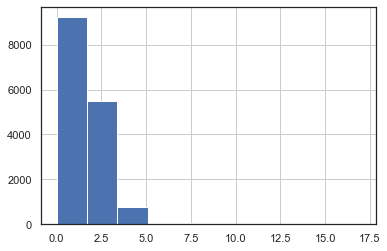

In [305]:
df.beds.hist()

## Bedrooms

<AxesSubplot:>

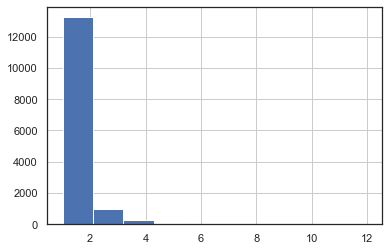

In [306]:
df.bedrooms.hist()

## Amenities

In [307]:
df.amenities[:1].values

array(['["TV", "Washer", "Heating", "First aid kit", "Kitchen", "Long term stays allowed", "Dryer", "Air conditioning", "Fire extinguisher", "Indoor fireplace", "Smoke alarm", "Essentials", "Wifi", "Shampoo"]'],
      dtype=object)

## Maximum & Minimum Nights [TODO]

In [308]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

## Availability [TODO]

In [309]:
# Figure out if well use availability_30 availability_60, availability_90 or availability_365
#Dropping all but 90 as a test

df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

# EDA - Exploratory Data Analysis

In [310]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [311]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 08 August 2008, and the most recent joined on 01 December 2021.


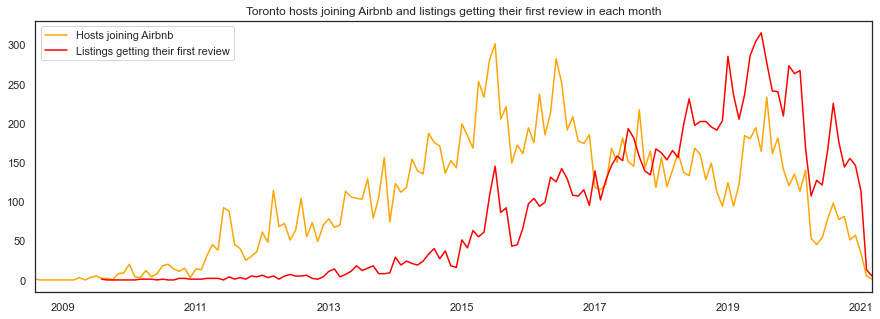

In [312]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('%s hosts joining Airbnb and listings getting their first review in each month' %cityName)
plt.legend()
plt.xlim('2008-08-21', '2021-03-20') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [313]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [314]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

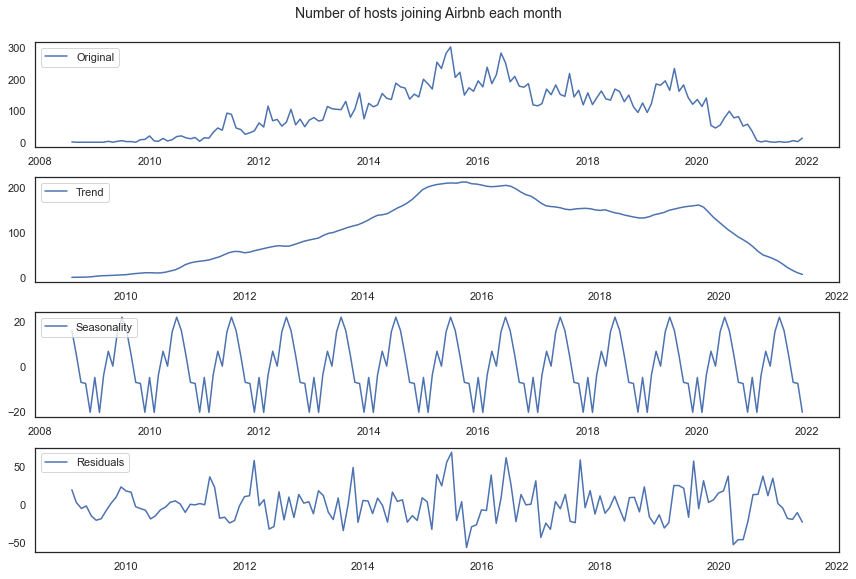

In [315]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

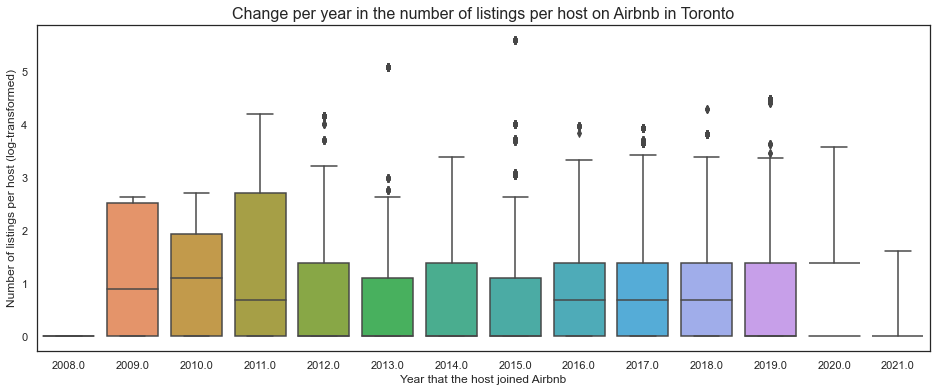

In [316]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in %s' %cityName, fontsize=16)
plt.show()



In [317]:
print("Average number of listings per host per year on Airbnb in Edinburgh:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Edinburgh:
host_since
2008-01-01     1.00
2009-01-01     6.56
2010-01-01     4.89
2011-01-01    12.12
2012-01-01     8.84
2013-01-01    12.55
2014-01-01     4.45
2015-01-01     6.80
2016-01-01     3.97
2017-01-01     5.86
2018-01-01     4.95
2019-01-01     5.75
2020-01-01     4.77
2021-01-01     0.72
Name: host_listings_count, dtype: float64


In [318]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
18396377,2016-12-01,53.0
45353062,2012-05-27,56.0
1547348,2012-03-13,64.0
46712198,2011-07-20,67.0
39940740,2018-06-07,74.0
43390391,2019-10-25,83.0
43269187,2019-08-09,89.0
45423520,2013-11-23,164.0
35147605,2015-07-14,272.0


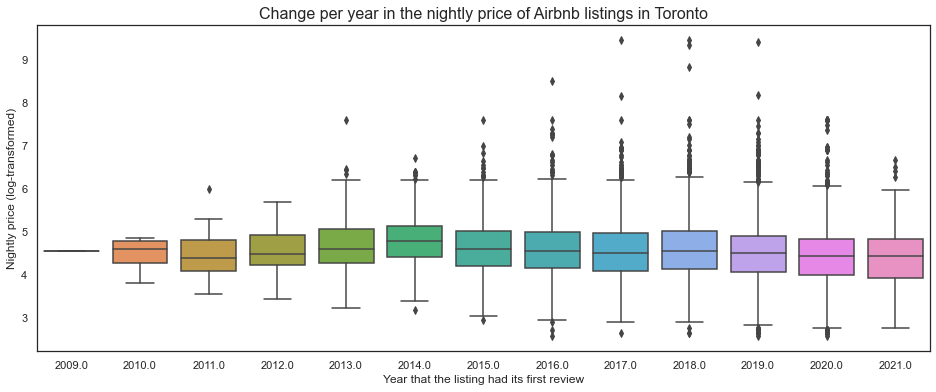

In [319]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in %s' %cityName, fontsize=16)
plt.show()

In [320]:
print("Mean nightly price of listings in each year on Airbnb in Edinburgh:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Edinburgh:
first_review
2009-01-01     96.00
2010-01-01     91.11
2011-01-01    106.85
2012-01-01    111.28
2013-01-01    152.81
2014-01-01    145.32
2015-01-01    130.85
2016-01-01    131.66
2017-01-01    131.05
2018-01-01    140.44
2019-01-01    124.78
2020-01-01    113.29
2021-01-01    109.61
Name: price, dtype: float64


In [321]:
print("Median nightly price of listings in each year on Airbnb in Edinburgh:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year on Airbnb in Edinburgh:
first_review
2009-01-01     96.0
2010-01-01    100.0
2011-01-01     81.0
2012-01-01     89.0
2013-01-01    100.0
2014-01-01    120.0
2015-01-01    100.0
2016-01-01     95.0
2017-01-01     91.0
2018-01-01     95.0
2019-01-01     90.0
2020-01-01     85.0
2021-01-01     84.5
Name: price, dtype: float64


In [322]:
df["price"].describe()

count    15832.000000
mean       136.679573
std        316.199774
min          0.000000
25%         60.000000
50%         93.000000
75%        148.000000
max      13000.000000
Name: price, dtype: float64

In [323]:
print(f"Advertised prices range from £{min(df.price)} to £{max(df.price)}.")

Advertised prices range from £0.0 to £13000.0.


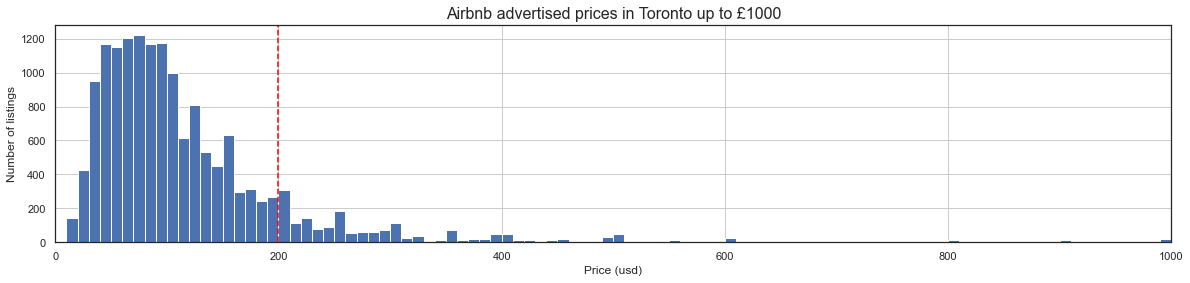

In [324]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised prices in %s up to £1000" %cityName, fontsize=16)
plt.xlabel("Price (usd)")
plt.ylabel("Number of listings")
plt.show()



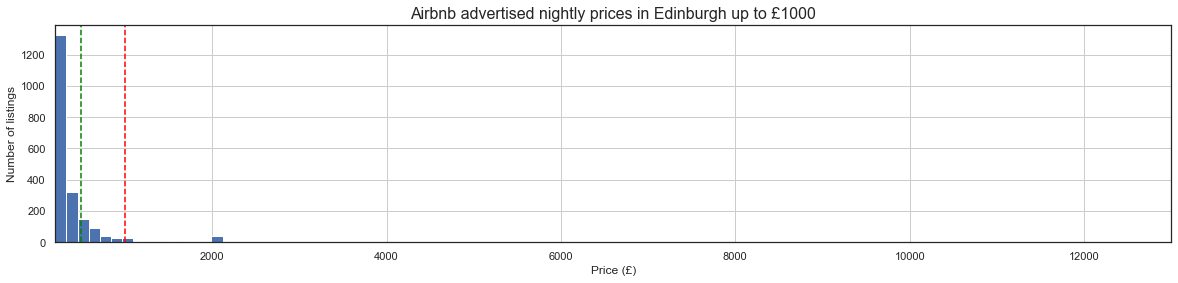

In [325]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Edinburgh up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()



In [326]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

In [327]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(df.host_listings_count.max())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 6
Highest number of listins per host: 272
39% of listings are from hosts with one listing.


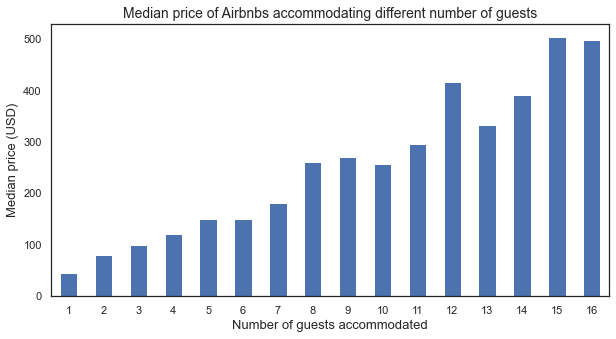

In [328]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (USD)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

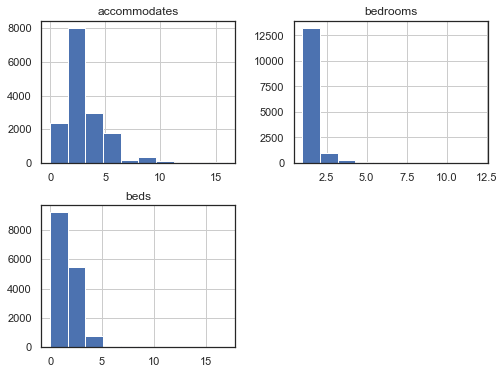

In [329]:
df[['accommodates', 'bedrooms', 'beds']].hist(figsize=(8,6));

# Categorical Features

In [330]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Edinburgh borough boundary GeoJSON file as a dataframe in geopandas
#map_df = pd.read_file(r'/resources/Data_Science_Capstone/neighbourhoods.geojson')
map_df = gpd.read_file(r'../input/Toronto/neighbourhoods.geojson')
map_df.head()


,neighbourhood,neighbourhood_group,geometry
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,The Beaches,None,"MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,Scarborough Village,None,"MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,South Parkdale,None,"MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,South Riverdale,None,"MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


In [331]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
York University Heights,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",153,42.0
The Beaches,"MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ...",135,98.0
Scarborough Village,"MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ...",19,59.0
South Parkdale,"MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ...",237,84.0
South Riverdale,"MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ...",286,105.0


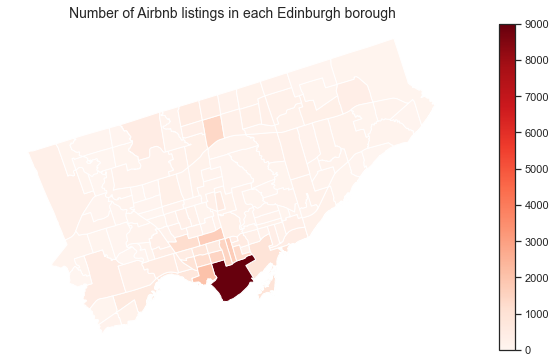

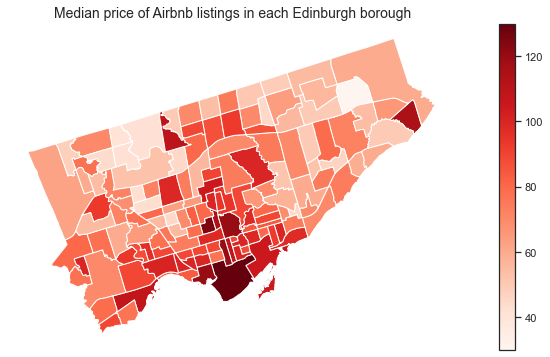

In [332]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [333]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

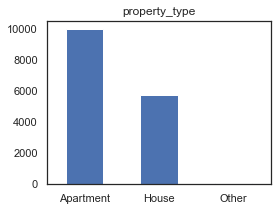

Apartment    0.631506
House        0.362683
Other        0.005811
Name: property_type, dtype: float64


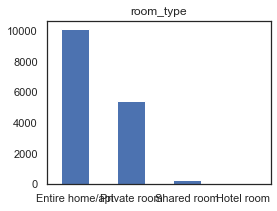

Entire home/apt    0.639338
Private room       0.342029
Shared room        0.015538
Hotel room         0.003095
Name: room_type, dtype: float64


In [334]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))



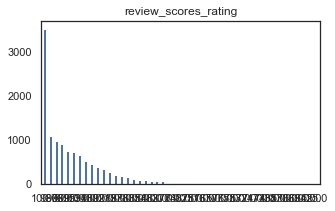

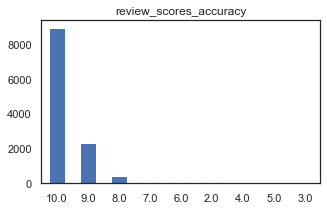

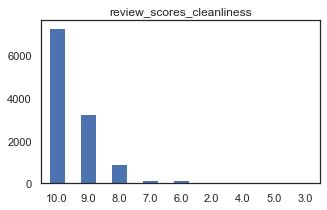

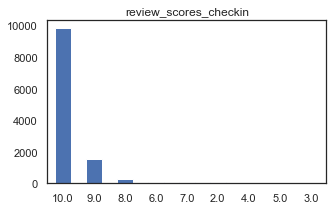

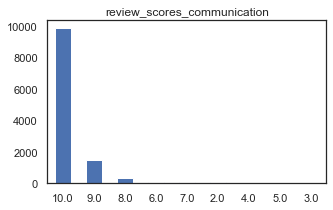

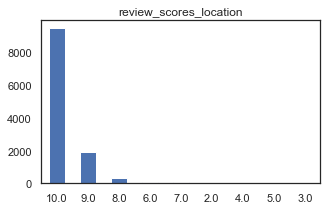

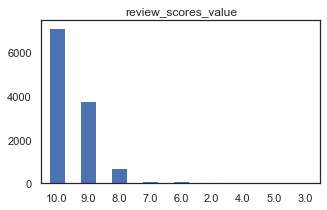

In [335]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

In [336]:
# Define Foursquare Credentials (https://docs.mageplaza.com/social-login-m2/how-to-configure-foursquare-api.html)

CLIENT_ID = "4KRML2FZ3XHF4AVRH2LFBA5N4PZ3QTMXLQIFTQXBQDO0K1V0" # your Foursquare ID
CLIENT_SECRET = "1XK4MIBN3BG02GSU50YEX3PTZUOHAADPGT51AHBEFFCJ31ZG"  # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4KRML2FZ3XHF4AVRH2LFBA5N4PZ3QTMXLQIFTQXBQDO0K1V0
CLIENT_SECRET:1XK4MIBN3BG02GSU50YEX3PTZUOHAADPGT51AHBEFFCJ31ZG


In [337]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [338]:
# Function to loop for venues through all neighbourhoods
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

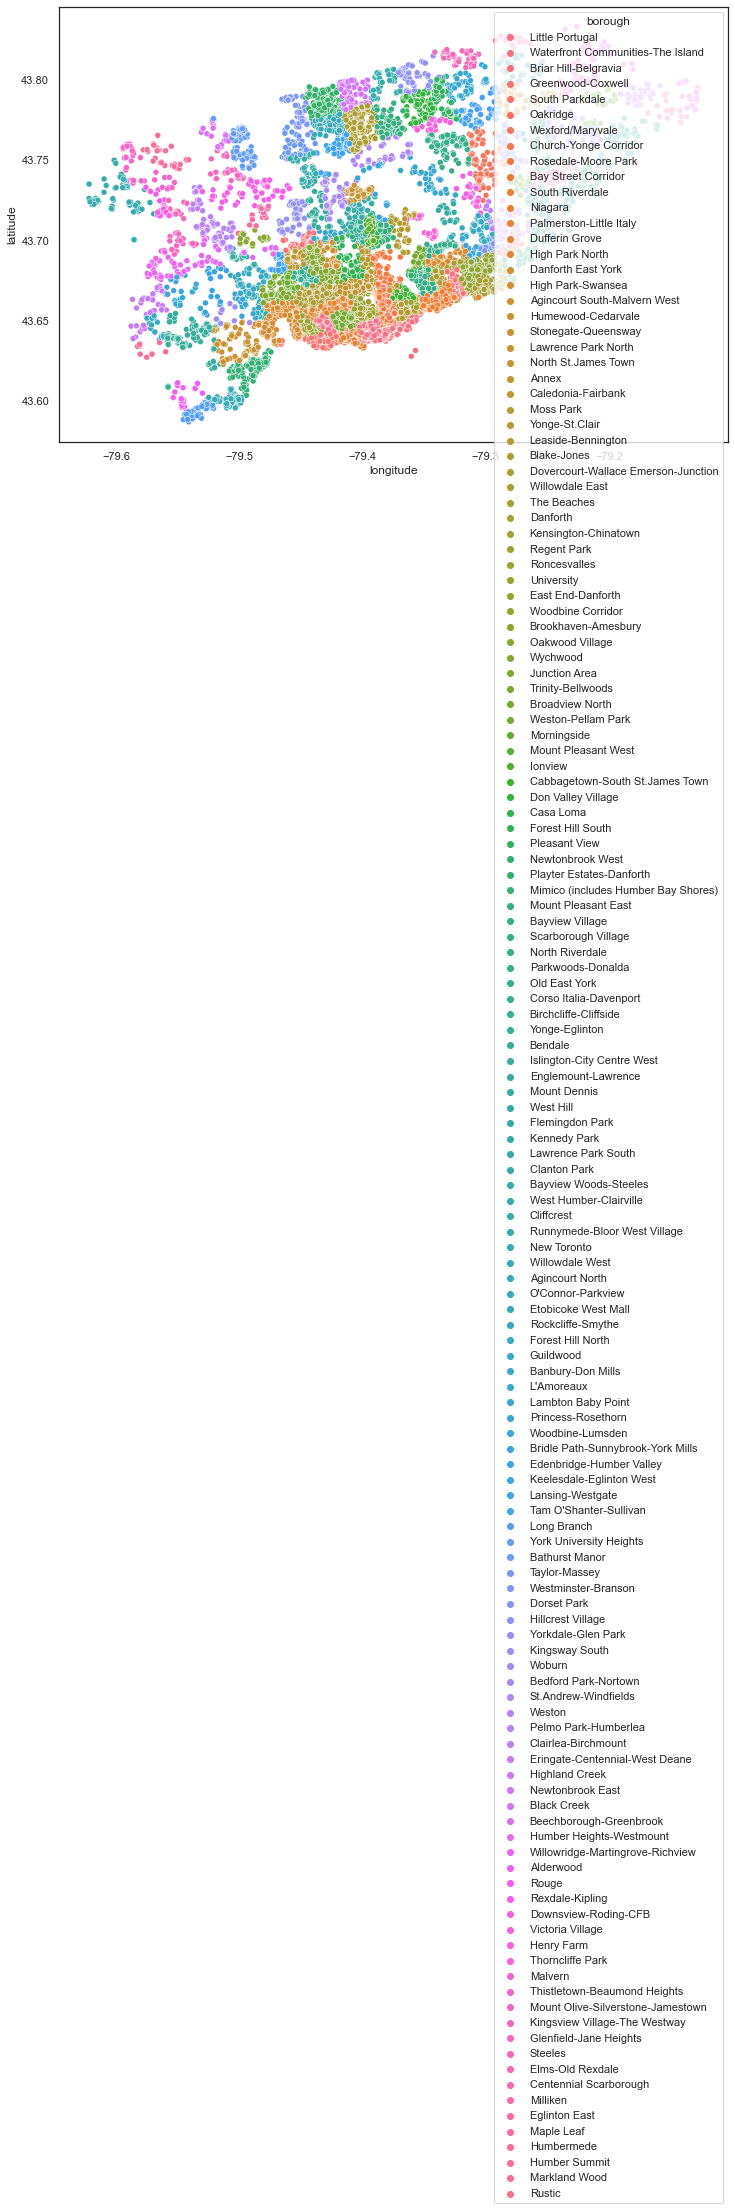

In [339]:

# Maybe rename those according to https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto? 
plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df["longitude"], df["latitude"], hue=df["borough"])
plt.ioff()

# 6 - Preparing Data for Modeling

## Making Dummy Variables

In [340]:
df = df.drop("host_since", axis=1)
df = df.drop("borough", axis=1)
df = df.drop("latitude", axis=1)
df = df.drop("longitude", axis=1)
#df = df.drop("property_type", axis=1)
#df = df.drop("room_type", axis=1)
df = df.drop("last_review", axis=1)
df = df.drop("first_review", axis=1)
df = df.drop("amenities", axis=1)
df = df.drop("bathrooms_text", axis=1)

print(df.columns)
df = pd.get_dummies(df)
print(df.columns)
df.head()



Index(['host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_90', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month'],
      dtype='object')
Index(['host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_90', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accura

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,review_scores_value,instant_bookable,reviews_per_month,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,,,,,,
1419,0.0,1.0,1.0,1.0,10,5.0,7.0,469.0,28,730,...,10.0,0,0.10,0,1,0,1,0,0,0
8077,0.0,2.0,1.0,0.0,2,1.0,1.0,96.0,180,365,...,10.0,1,1.21,1,0,0,0,0,1,0
23691,0.0,2.0,1.0,1.0,3,1.0,1.0,72.0,28,28,...,10.0,1,1.66,0,1,0,0,0,1,0
27423,0.0,1.0,1.0,1.0,1,NaN,1.0,45.0,365,365,...,10.0,0,0.20,1,0,0,1,0,0,0
30931,0.0,2.0,1.0,0.0,2,1.0,2.0,128.0,180,365,...,NaN,0,0.01,1,0,0,1,0,0,0


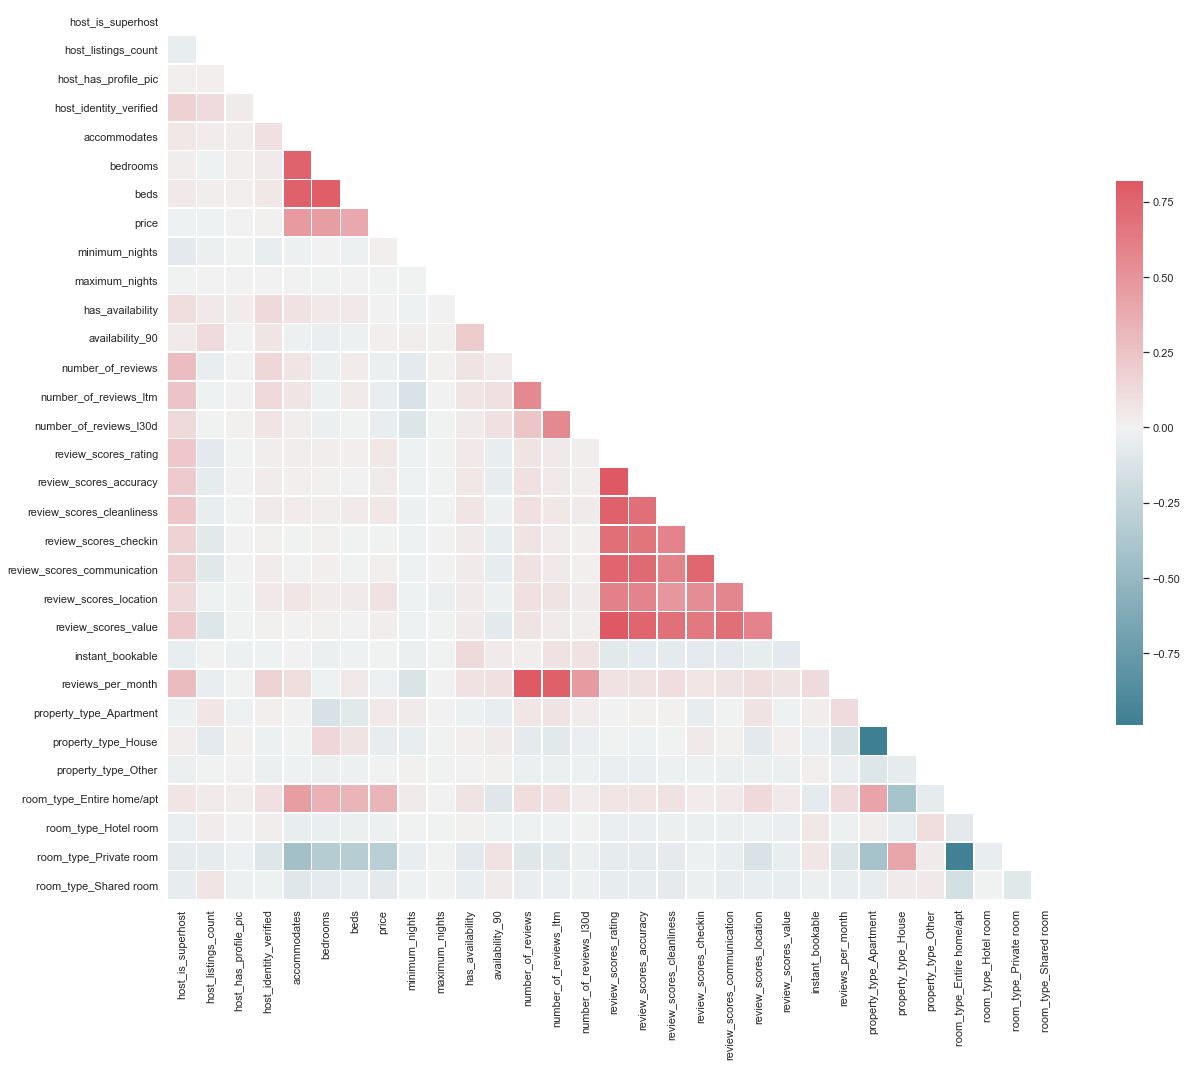

In [341]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True 

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

multi_collinearity_heatmap(df, figsize=(20,20))

In [342]:
# Dropping collinear Features



array([[<AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'availability_90'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>],
       [<AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'number_of_reviews'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

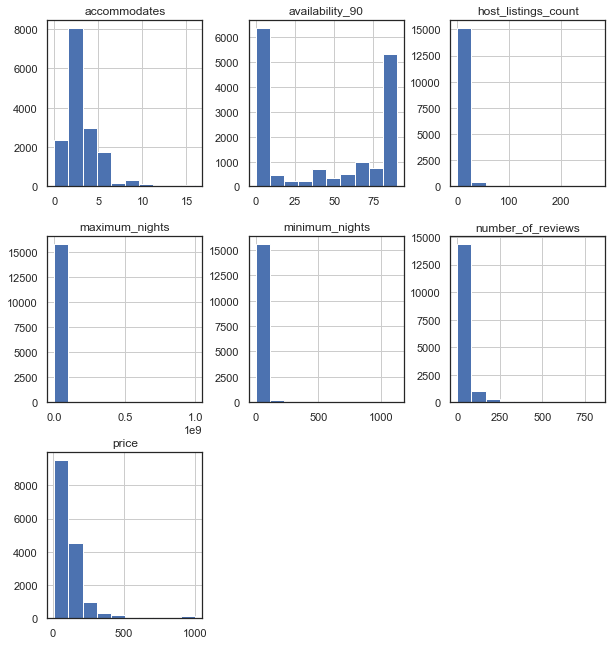

In [343]:
numerical_columns = ['accommodates', 'availability_90','host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price']
df[numerical_columns].hist(figsize=(10,11));


In [344]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[col] = np.log(df[col])

In [345]:
#df.drop('first_review', axis=1, inplace=True)
df.describe()

df = df.fillna(0) # this is NOT a long-term solution

In [346]:
# Separating X and y
X = df.drop('price', axis=1)
y = df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))


# 7 - Modelling

In [347]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1092867)

In [348]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.2709
Validation RMSE: 0.2553

Training r2: 0.4581
Validation r2: 0.5042


## XGBoost (74% r2, 58% validation)

In [349]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 0.1301
Validation MSE: 0.2139

Training r2: 0.7398
Validation r2: 0.5846


## Importance Weights

In [350]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
room_type_Entire home/apt,0.735750
property_type_House,0.043809
room_type_Shared room,0.040541
bedrooms,0.026993
accommodates,0.022632
has_availability,0.010501
review_scores_location,0.008745
availability_90,0.007348
room_type_Private room,0.007269
review_scores_communication,0.006680


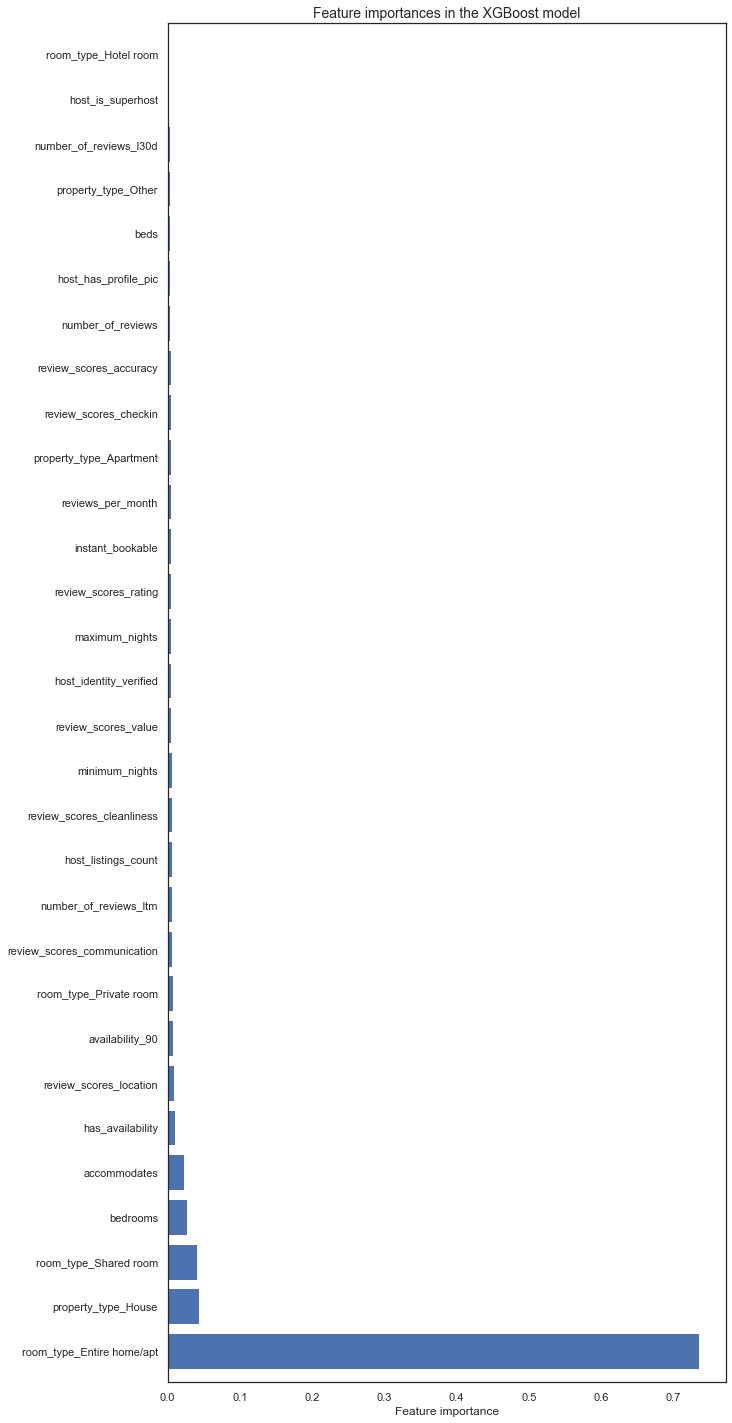

In [351]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)

# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Text(0, 0.5, 'Median price (usd)')

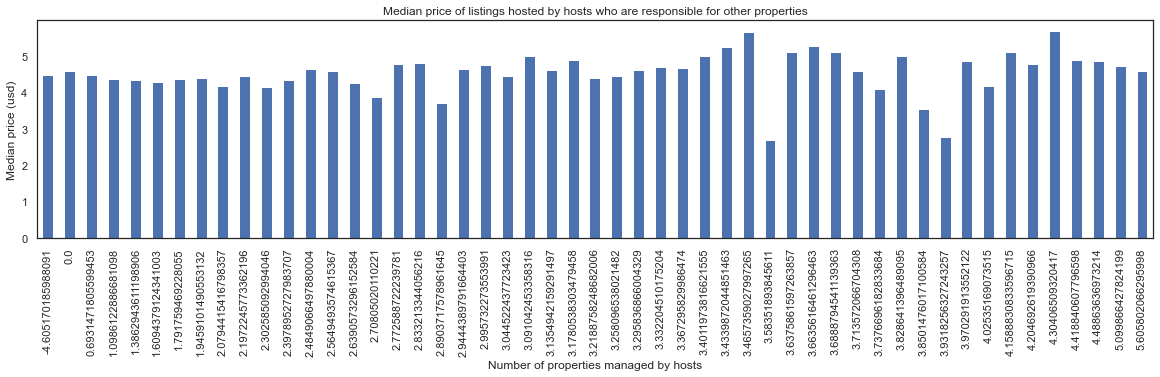

In [352]:
# Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (usd)')

In [353]:
# Dropping Columns

all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)



## 3 - Hedonic Regression w/ dropped Columns

In [354]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg2 = LinearRegression()  
hpm_reg2.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg2 = hpm_reg2.predict(X_train)
val_preds_hpm_reg2 = hpm_reg2.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg2),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg2),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.2709
Validation RMSE: 0.2553

Training r2: 0.4581
Validation r2: 0.5042


## 4 - XGBoost with dropped columns

In [355]:

xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg2),4))

Time taken to run: 0.0 minutes

Training MSE: 0.1301
Validation MSE: 0.2139

Training r2: 0.7398
Validation r2: 0.5846
